In [43]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import copy
from torch.utils.data import DataLoader,  TensorDataset
from sklearn.utils import shuffle
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing
from torchsummary import summary
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import data_challenge_library as dcl

In [2]:
object_table = dcl.load_table(have_images = True)
object_table, validation_table = train_test_split(object_table, test_size = 0.1, random_state= 2121805)

table has 446487 sources
class
Gal         246225
Star         96715
Qso          83130
Agn           5608
highZQso      1089
Name: count, dtype: int64
Keeping 432767 labeled sources
Keeping 142963 with all features used in Savic+23
Keeping 142963 with available cutouts


In [4]:
X = object_table.drop(columns=["class", "label"])
y = object_table["label"].to_numpy().astype('int32')
objectID = object_table.index
X, y, objectID = shuffle(X, y, objectID, random_state = 2605)

In [22]:
X_train, X_test, y_train, y_test, objectID_train, objectID_test = train_test_split(X, y, 
                                objectID, test_size = 0.5, random_state = 1406)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
display(X_train.shape, X_test.shape)

(64333, 62)

(64333, 62)

In [23]:
train_images = dcl.load_images(objectID_train, as_tensor = True)
test_images = dcl.load_images(objectID_test, as_tensor = True)

In [11]:
###Define a general Dense Neural network
class general_MLP(nn.Module):
    def __init__(self, input_size, output_size, N_hidden = 0, hidden_sizes =[],
                activation_function = nn.LeakyReLU(), seed = 26052013):
        super(general_MLP, self).__init__()
        
        self.seed = seed
        
        if N_hidden > 0:
            assert len(hidden_sizes) == N_hidden
            first_layer_out = hidden_sizes[0]
            last_layer_in = hidden_sizes[-1]
        else:
            first_layer_out = output_size 
            last_layer_in = output_size 
        
        self.activation_function = activation_function
        
        self.first_layer = nn.Sequential(
                           nn.Linear(input_size, first_layer_out),
                           self.activation_function)
        

        
        hidden_layers =[]
        for N_in, N_out  in zip(hidden_sizes[:-1],hidden_sizes[1:]):
            
            hidden_layers.append(nn.Linear(N_in, N_out))
            hidden_layers.append(self.activation_function)
       
        
        self.hidden_layers = nn.Sequential(*hidden_layers)

        self.last_layer = nn.Linear(last_layer_in, output_size)
        
        
    def forward(self, x):
        x = self.first_layer(x)
        x = self.hidden_layers(x)
        x = self.last_layer(x)
        
        return x

In [12]:
###Uses images+tabular data
class merged_model(nn.Module):
    def __init__(self):
        super(merged_model,self).__init__()
        
        self.process_tabular = general_MLP(input_size = 62, output_size = 30, N_hidden = 1, hidden_sizes =[62],
                activation_function = nn.LeakyReLU())
        
        self.process_image = nn.Sequential(
                                   #nn.Conv2d(3, 12, 2),
                                   #nn.LeakyReLU(),
                                   nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.process_flattened_image = general_MLP(input_size = 3*8*8, output_size = 30, 
                                                   N_hidden = 1, hidden_sizes =[30])
        
        self.process_both = general_MLP(input_size = 60, output_size = 3, 
                                                   N_hidden = 1, hidden_sizes =[30])
        
    def forward(self, image, tabular):
        
        image = self.process_image(image)
        image = torch.flatten(image, 1)
        image = self.process_flattened_image(image)
        
        tabular = self.process_tabular(tabular)
        
        out = torch.concat([image, tabular], dim =1)

        out = self.process_both(out)
        
        return out

In [21]:
def train_routine(dataloader, model, loss_fn, optimizer, verbose = True):
    losses = []
    num_batches = len(dataloader)
    for batch, (images, features, labels) in enumerate(dataloader): 
        output = model(images, features)
        loss = loss_fn(output, labels)

        # Backpropagation
        optimizer.zero_grad()    # Clear the gradient
        loss.backward()          # Compute the gradient (??)
        optimizer.step()         # update model weights

        
        if batch == round(num_batches/2):
            losses.append(loss.item())
            if verbose:
                print(f"loss: {loss:>7f}")

    return losses

def test_routine(dataloader, model, loss_fn, verbose = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    model.eval() 
    with torch.no_grad():
        for images, features, labels in dataloader:
            output = model(images, features)
            test_loss += loss_fn(output, labels).item()

    test_loss /= num_batches
    if verbose:
        print(f" Avg test loss      : {test_loss:>8f}")

    return test_loss

In [24]:
X_train, y_train = dcl.transform2tensor(X_train, y_train)
X_test, y_test = dcl.transform2tensor(X_test, y_test)

In [40]:
train_dataset = TensorDataset(train_images, X_train,  y_train)
test_dataset = TensorDataset(test_images, X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size= 40, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= 40, shuffle=True)

In [41]:
modello = merged_model()
EPOCHS = 60
SEED = 12
loss_fn = torch.nn.CrossEntropyLoss()  #torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD(modello.parameters(), lr=0.001, weight_decay=0.1)

In [42]:
train_loss = []
test_loss  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}")
    train_loss.append(train_routine(train_dataloader, modello, loss_fn, optimizer, verbose = False))
    test_loss.append(test_routine(test_dataloader, modello, loss_fn, verbose = True))
print("Done!")

Epoch 1
 Avg test loss      : 0.918118
Epoch 2
 Avg test loss      : 0.662427
Epoch 3
 Avg test loss      : 0.464289
Epoch 4
 Avg test loss      : 0.304530
Epoch 5
 Avg test loss      : 0.227420
Epoch 6
 Avg test loss      : 0.200848
Epoch 7
 Avg test loss      : 0.190154
Epoch 8
 Avg test loss      : 0.184283
Epoch 9
 Avg test loss      : 0.181655
Epoch 10
 Avg test loss      : 0.179685
Epoch 11
 Avg test loss      : 0.178326
Epoch 12
 Avg test loss      : 0.177133
Epoch 13
 Avg test loss      : 0.176275
Epoch 14
 Avg test loss      : 0.175915
Epoch 15
 Avg test loss      : 0.175598
Epoch 16
 Avg test loss      : 0.174931
Epoch 17
 Avg test loss      : 0.174961
Epoch 18
 Avg test loss      : 0.174758
Epoch 19
 Avg test loss      : 0.174607
Epoch 20
 Avg test loss      : 0.174789
Epoch 21
 Avg test loss      : 0.174639
Epoch 22
 Avg test loss      : 0.174198
Epoch 23
 Avg test loss      : 0.174239
Epoch 24
 Avg test loss      : 0.174425
Epoch 25
 Avg test loss      : 0.174366
Epoch 26


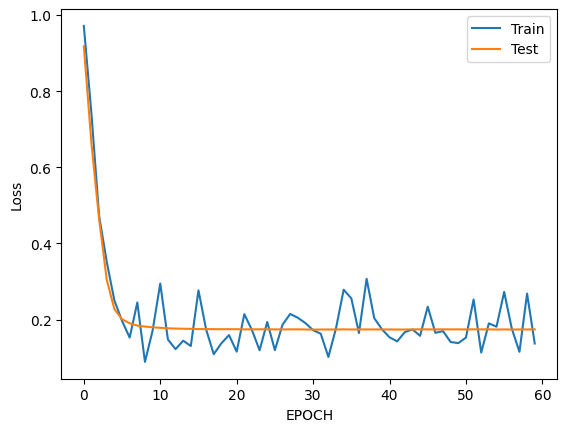

In [44]:
fig, ax = plt.subplots()
ax.plot(np.arange(EPOCHS), train_loss, label ='Train')
ax.plot(np.arange(EPOCHS), test_loss, label ='Test')
ax.set_xlabel("EPOCH")
ax.set_ylabel("Loss")
ax.legend()

[0.97647475 0.97844486 0.93678624]
0.9680257410660159


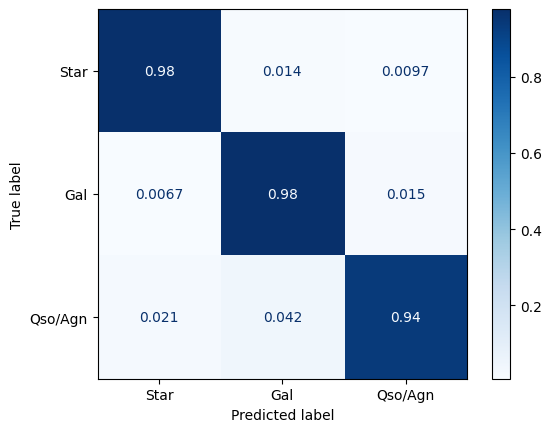

In [45]:
predictions = modello(test_images, X_test)
predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_test.numpy(), predictions, normalize="true")

str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_test.numpy(), predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot(cmap = mpl.cm.Blues)



In [47]:
modello_nodecay = merged_model()
EPOCHS = 60
SEED = 12
loss_fn = torch.nn.CrossEntropyLoss()  #torch.nn.CrossEntropyLoss
optimizer = torch.optim.SGD(modello_nodecay.parameters(), lr=0.001, weight_decay=0.01)

In [48]:
train_loss_nd = []
test_loss_nd  = []
for t in range(EPOCHS):
    print(f"Epoch {t+1}")
    train_loss_nd.append(train_routine(train_dataloader, modello_nodecay, loss_fn, optimizer, verbose = False))
    test_loss_nd.append(test_routine(test_dataloader, modello_nodecay, loss_fn, verbose = True))
print("Done!")

Epoch 1
 Avg test loss      : 0.957077
Epoch 2
 Avg test loss      : 0.549249
Epoch 3
 Avg test loss      : 0.225071
Epoch 4
 Avg test loss      : 0.145228
Epoch 5
 Avg test loss      : 0.122114
Epoch 6
 Avg test loss      : 0.111694
Epoch 7
 Avg test loss      : 0.105720
Epoch 8
 Avg test loss      : 0.101861
Epoch 9
 Avg test loss      : 0.099044
Epoch 10
 Avg test loss      : 0.097185
Epoch 11
 Avg test loss      : 0.095483
Epoch 12
 Avg test loss      : 0.094191
Epoch 13
 Avg test loss      : 0.093111
Epoch 14
 Avg test loss      : 0.092234
Epoch 15
 Avg test loss      : 0.091493
Epoch 16
 Avg test loss      : 0.090812
Epoch 17
 Avg test loss      : 0.090194
Epoch 18
 Avg test loss      : 0.089730
Epoch 19
 Avg test loss      : 0.089227
Epoch 20
 Avg test loss      : 0.088813
Epoch 21
 Avg test loss      : 0.088454
Epoch 22
 Avg test loss      : 0.088075
Epoch 23
 Avg test loss      : 0.087851
Epoch 24
 Avg test loss      : 0.087428
Epoch 25
 Avg test loss      : 0.087150
Epoch 26


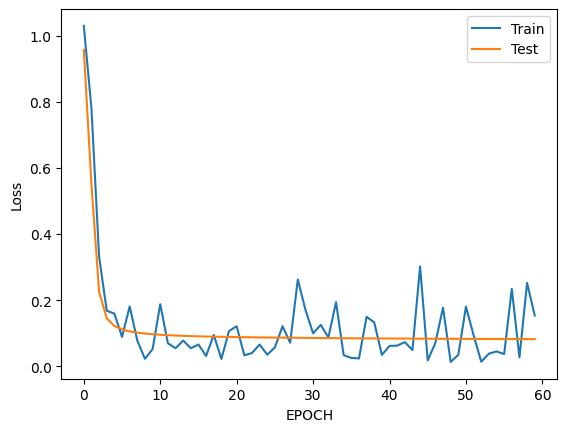

In [49]:
fig, ax = plt.subplots()
ax.plot(np.arange(EPOCHS), train_loss_nd, label ='Train')
ax.plot(np.arange(EPOCHS), test_loss_nd, label ='Test')
ax.set_xlabel("EPOCH")
ax.set_ylabel("Loss")
ax.legend()

[0.98794282 0.98015426 0.9528416 ]
0.97691697884445


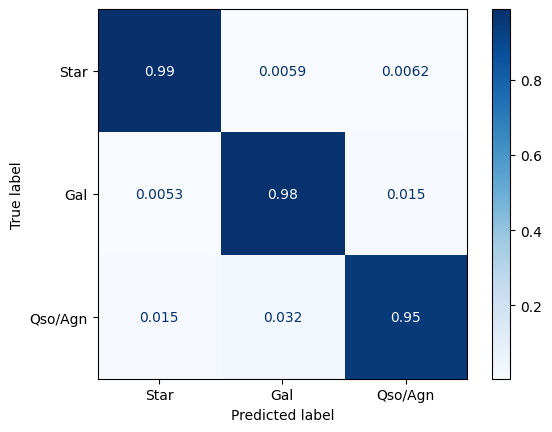

In [50]:
predictions = modello_nodecay(test_images, X_test)
predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_test.numpy(), predictions, normalize="true")

str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_test.numpy(), predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot(cmap = mpl.cm.Blues)

## Validation

In [59]:
validation_images = dcl.load_images(validation_table.index, as_tensor=True)
X_validation = validation_table.drop(columns=["class", "label"]).to_numpy()
X_validation = scaler.transform(X_validation)
y_validation = validation_table["label"].to_numpy().astype('int32')
X_validation, y_validation = dcl.transform2tensor(X_validation, y_validation)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[0.98806555 0.98232558 0.94860943]
0.9767783451073652

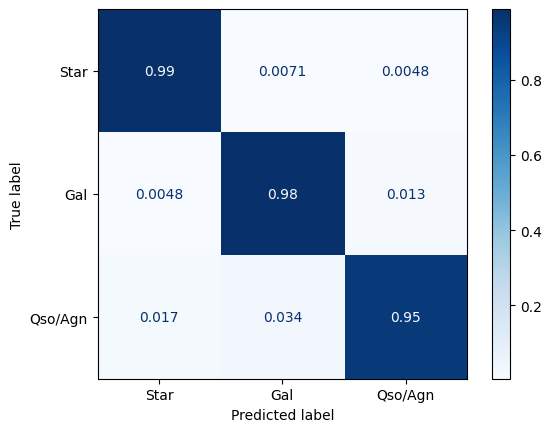

In [60]:
predictions = modello_nodecay(validation_images, X_validation)
predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_validation.numpy(), predictions, normalize="true")


str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_validation.numpy(), predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot(cmap = mpl.cm.Blues)



[0.97595297 0.98065116 0.93833132]
0.9690144785619361

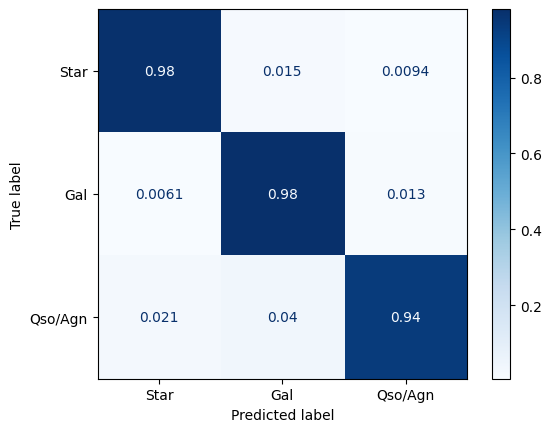

In [61]:
predictions = modello(validation_images, X_validation)
predictions = predictions.detach().numpy()
predictions = np.argmax(predictions, axis =1)
cf = confusion_matrix(y_validation.numpy(), predictions, normalize="true")


str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(accuracy_score(y_validation.numpy(), predictions))
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot(cmap = mpl.cm.Blues)

In [1]:
model = nn.MaxPool2d(1)

NameError: name 'nn' is not defined